# 01 - Esplorazione e Analisi dei Dataset

Questo notebook esplora i dataset disponibili per il progetto di classificazione della retinopatia diabetica.

## Dataset Analizzati
- **APTOS 2019**: Dataset Kaggle per DR grading
- **EyePACS 2015**: Dataset Kaggle di grandi dimensioni
- **Messidor-2**: Dataset per validazione esterna
- **DDR**: Dataset con annotazioni pixel-level per XAI validation

## Obiettivi
1. Analizzare la struttura di ogni dataset
2. Unificare i formati delle label
3. Visualizzare la distribuzione delle classi
4. Identificare problemi (immagini ungradable, dati mancanti)

## 1. Import delle Librerie

In [27]:
# Librerie standard
import os
import sys
from pathlib import Path

# Manipolazione dati
import pandas as pd
import numpy as np

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazioni di visualizzazione
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# =============================================================================
# CONFIGURAZIONE PERCORSI
# =============================================================================
# Il notebook rileva automaticamente se e in esecuzione su WSL o Windows
# e configura i percorsi di conseguenza.

def get_project_root():
    """
    Rileva la root del progetto in modo robusto.
    Funziona sia su Windows nativo che su WSL.
    
    Returns:
        Path: Percorso alla root del progetto
    """
    # Partiamo dalla directory del notebook
    notebook_dir = Path.cwd()
    
    # Se siamo in 'notebooks', la root e la cartella padre
    if notebook_dir.name == 'notebooks':
        return notebook_dir.parent
    
    # Altrimenti cerchiamo la cartella 'Data' risalendo
    current = notebook_dir
    for _ in range(5):  # Massimo 5 livelli
        if (current / 'Data').exists():
            return current
        current = current.parent
    
    # Fallback: percorso assoluto (modificare se necessario)
    # Per WSL: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy
    # Per Windows: C:/Repository/multi-method-xai-diabetic-retinopathy
    if sys.platform == 'linux' and Path('/mnt/c').exists():
        # Siamo su WSL
        return Path('/mnt/c/Repository/multi-method-xai-diabetic-retinopathy')
    else:
        # Windows nativo
        return Path('C:/Repository/multi-method-xai-diabetic-retinopathy')

# Configurazione percorsi
PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / 'Data'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Creazione directory results se non esiste
RESULTS_DIR.mkdir(exist_ok=True)

# Verifica che i percorsi siano corretti
print("Configurazione Percorsi")
print("=" * 60)
print(f"Sistema operativo: {sys.platform}")
print(f"Directory corrente: {Path.cwd()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Data directory esiste: {DATA_DIR.exists()}")

# Lista contenuto della cartella Data per verifica
if DATA_DIR.exists():
    print(f"\nContenuto di {DATA_DIR}:")
    for item in DATA_DIR.iterdir():
        print(f"  - {item.name}/")

Configurazione Percorsi
Sistema operativo: linux
Directory corrente: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy
Project root: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy
Data directory: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data
Data directory esiste: True

Contenuto di /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data:
  - APTOS2019/
  - DDR Dataset/
  - EyePACS2015/
  - messidor-2/
  - processed/


## 2. Definizione delle Classi DR

La scala internazionale per la classificazione della retinopatia diabetica prevede 5 livelli:

In [28]:
# Mappatura delle classi di Retinopatia Diabetica
# Scala internazionale: 0-4
DR_CLASSES = {
    0: 'No DR',           # Nessuna retinopatia
    1: 'Mild',            # Retinopatia lieve (solo microaneurismi)
    2: 'Moderate',        # Retinopatia moderata
    3: 'Severe',          # Retinopatia severa (non proliferativa)
    4: 'Proliferative'    # Retinopatia proliferativa (stadio avanzato)
}

# Colori per i grafici (dal verde al rosso per indicare gravita)
DR_COLORS = {
    0: '#2ecc71',  # Verde - No DR
    1: '#f1c40f',  # Giallo - Mild
    2: '#e67e22',  # Arancione - Moderate
    3: '#e74c3c',  # Rosso - Severe
    4: '#9b59b6'   # Viola - Proliferative
}

# Stampa la legenda delle classi
print("Classi di Retinopatia Diabetica:")
print("-" * 40)
for code, name in DR_CLASSES.items():
    print(f"  {code}: {name}")

Classi di Retinopatia Diabetica:
----------------------------------------
  0: No DR
  1: Mild
  2: Moderate
  3: Severe
  4: Proliferative


## 3. Caricamento Dataset APTOS 2019

Il dataset APTOS 2019 e stato rilasciato per una competizione Kaggle sulla diagnosi della DR.

**Struttura:**
- File CSV con colonne: `id_code`, `diagnosis`
- Le immagini sono in formato PNG
- Label da 0 a 4

In [29]:
# Percorsi dataset APTOS
APTOS_DIR = DATA_DIR / 'APTOS2019'

# Caricamento dei file CSV
# train_1.csv contiene le immagini di training con label
aptos_train = pd.read_csv(APTOS_DIR / 'train_1.csv')
aptos_valid = pd.read_csv(APTOS_DIR / 'valid.csv')

# Visualizzazione delle prime righe
print("APTOS 2019 - Training Set")
print(f"Numero di immagini: {len(aptos_train)}")
print(f"Colonne: {list(aptos_train.columns)}")
print("\nPrime 5 righe:")
display(aptos_train.head())

print("\n" + "="*50)
print("\nAPTOS 2019 - Validation Set")
print(f"Numero di immagini: {len(aptos_valid)}")
display(aptos_valid.head())

APTOS 2019 - Training Set
Numero di immagini: 2930
Colonne: ['id_code', 'diagnosis']

Prime 5 righe:


,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0




APTOS 2019 - Validation Set
Numero di immagini: 366


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [30]:
# Analisi distribuzione classi APTOS
print("Distribuzione classi - APTOS Training:")
aptos_train_dist = aptos_train['diagnosis'].value_counts().sort_index()
for label, count in aptos_train_dist.items():
    pct = count / len(aptos_train) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count} ({pct:.1f}%)")

print("\nDistribuzione classi - APTOS Validation:")
aptos_valid_dist = aptos_valid['diagnosis'].value_counts().sort_index()
for label, count in aptos_valid_dist.items():
    pct = count / len(aptos_valid) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count} ({pct:.1f}%)")

Distribuzione classi - APTOS Training:
  Classe 0 (No DR): 1434 (48.9%)
  Classe 1 (Mild): 300 (10.2%)
  Classe 2 (Moderate): 808 (27.6%)
  Classe 3 (Severe): 154 (5.3%)
  Classe 4 (Proliferative): 234 (8.0%)

Distribuzione classi - APTOS Validation:
  Classe 0 (No DR): 172 (47.0%)
  Classe 1 (Mild): 40 (10.9%)
  Classe 2 (Moderate): 104 (28.4%)
  Classe 3 (Severe): 22 (6.0%)
  Classe 4 (Proliferative): 28 (7.7%)


## 4. Caricamento Dataset EyePACS 2015

EyePACS e il dataset piu grande disponibile per la DR, proveniente da una competizione Kaggle del 2015.

**Struttura:**
- File CSV con colonne: `image`, `level`
- Le immagini sono in formato JPEG
- Il nome immagine NON include l'estensione nel CSV
- Label da 0 a 4

In [31]:
# Percorsi dataset EyePACS
EYEPACS_DIR = DATA_DIR / 'EyePACS2015'

# Caricamento del file delle label
eyepacs_labels = pd.read_csv(EYEPACS_DIR / 'trainLabels.csv')

# Rinomina le colonne per uniformita con gli altri dataset
eyepacs_labels = eyepacs_labels.rename(columns={
    'image': 'id_code',
    'level': 'diagnosis'
})

print("EyePACS 2015 - Training Set")
print(f"Numero di immagini: {len(eyepacs_labels)}")
print(f"Colonne originali: image, level")
print(f"Colonne rinominate: {list(eyepacs_labels.columns)}")
print("\nPrime 5 righe:")
display(eyepacs_labels.head())

EyePACS 2015 - Training Set
Numero di immagini: 35126
Colonne originali: image, level
Colonne rinominate: ['id_code', 'diagnosis']

Prime 5 righe:


,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [32]:
# Analisi distribuzione classi EyePACS
print("Distribuzione classi - EyePACS:")
eyepacs_dist = eyepacs_labels['diagnosis'].value_counts().sort_index()
for label, count in eyepacs_dist.items():
    pct = count / len(eyepacs_labels) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count} ({pct:.1f}%)")

print(f"\nTotale: {len(eyepacs_labels)} immagini")

Distribuzione classi - EyePACS:
  Classe 0 (No DR): 25810 (73.5%)
  Classe 1 (Mild): 2443 (7.0%)
  Classe 2 (Moderate): 5292 (15.1%)
  Classe 3 (Severe): 873 (2.5%)
  Classe 4 (Proliferative): 708 (2.0%)

Totale: 35126 immagini


## 5. Caricamento Dataset Messidor-2

Messidor-2 e un dataset di riferimento per la validazione esterna dei modelli di DR.

**Struttura:**
- File CSV con colonne: `image_id`, `adjudicated_dr_grade`, `adjudicated_dme`, `adjudicated_gradable`
- Le immagini sono in formato PNG/TIF
- Include informazioni aggiuntive su DME (Diabetic Macular Edema) e gradability
- Label da 0 a 4

In [33]:
# Percorsi dataset Messidor-2
MESSIDOR_DIR = DATA_DIR / 'messidor-2'

# Caricamento del file CSV
messidor_raw = pd.read_csv(MESSIDOR_DIR / 'messidor_data.csv')

print("Messidor-2 - Raw Data")
print(f"Numero di righe: {len(messidor_raw)}")
print(f"Colonne: {list(messidor_raw.columns)}")
print("\nPrime 5 righe:")
display(messidor_raw.head())

# Verifica valori mancanti
print("\nValori mancanti per colonna:")
print(messidor_raw.isnull().sum())

Messidor-2 - Raw Data
Numero di righe: 1748
Colonne: ['image_id', 'adjudicated_dr_grade', 'adjudicated_dme', 'adjudicated_gradable']

Prime 5 righe:


,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0.0,0.0,1
1,20051020_43832_0100_PP.png,1.0,0.0,1
2,20051020_43882_0100_PP.png,1.0,0.0,1
3,20051020_43906_0100_PP.png,2.0,1.0,1
4,20051020_44261_0100_PP.png,0.0,0.0,1



Valori mancanti per colonna:
image_id                0
adjudicated_dr_grade    4
adjudicated_dme         4
adjudicated_gradable    0
dtype: int64


In [34]:
# Pulizia dataset Messidor-2
# Rimuoviamo le righe con valori mancanti e filtriamo solo le immagini gradabili

# Rimozione righe con image_id mancante
messidor_clean = messidor_raw.dropna(subset=['image_id']).copy()

# Filtro per immagini gradabili (adjudicated_gradable == 1)
messidor_gradable = messidor_clean[messidor_clean['adjudicated_gradable'] == 1].copy()

# Selezione e rinomina colonne per uniformita
messidor = messidor_gradable[['image_id', 'adjudicated_dr_grade']].copy()
messidor = messidor.rename(columns={
    'image_id': 'id_code',
    'adjudicated_dr_grade': 'diagnosis'
})

# Conversione diagnosis a intero
messidor['diagnosis'] = messidor['diagnosis'].astype(int)

print("Messidor-2 - Dataset Pulito")
print(f"Immagini totali originali: {len(messidor_raw)}")
print(f"Immagini dopo pulizia: {len(messidor_clean)}")
print(f"Immagini gradabili: {len(messidor)}")
print("\nPrime 5 righe:")
display(messidor.head())

Messidor-2 - Dataset Pulito
Immagini totali originali: 1748
Immagini dopo pulizia: 1748
Immagini gradabili: 1744

Prime 5 righe:


,id_code,diagnosis
0,20051020_43808_0100_PP.png,0
1,20051020_43832_0100_PP.png,1
2,20051020_43882_0100_PP.png,1
3,20051020_43906_0100_PP.png,2
4,20051020_44261_0100_PP.png,0


In [35]:
# Analisi distribuzione classi Messidor-2
print("Distribuzione classi - Messidor-2 (solo gradabili):")
messidor_dist = messidor['diagnosis'].value_counts().sort_index()
for label, count in messidor_dist.items():
    pct = count / len(messidor) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count} ({pct:.1f}%)")

print(f"\nTotale: {len(messidor)} immagini")

Distribuzione classi - Messidor-2 (solo gradabili):
  Classe 0 (No DR): 1017 (58.3%)
  Classe 1 (Mild): 270 (15.5%)
  Classe 2 (Moderate): 347 (19.9%)
  Classe 3 (Severe): 75 (4.3%)
  Classe 4 (Proliferative): 35 (2.0%)

Totale: 1744 immagini


## 6. Caricamento Dataset DDR

DDR (Diabetic Retinopathy Detection) e un dataset cinese con annotazioni pixel-level per le lesioni.

**Struttura:**
- File TXT con formato: `filename label` (separati da spazio)
- Label da 0 a 5, dove **5 = ungradable** (da escludere)
- Include annotazioni per segmentazione delle lesioni (utili per XAI validation)

**Importante:** La classe 5 rappresenta immagini non valutabili e deve essere esclusa dal training.

In [36]:
# Percorsi dataset DDR
DDR_DIR = DATA_DIR / 'DDR Dataset' / 'DDR-dataset' / 'DR_grading'

def load_ddr_annotations(filepath):
    """
    Carica le annotazioni DDR da un file TXT.
    
    Il formato del file e: filename label (separati da spazio)
    
    Args:
        filepath: Percorso al file .txt delle annotazioni
        
    Returns:
        DataFrame con colonne 'id_code' e 'diagnosis'
    """
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            # Split per spazio: primo elemento e il filename, secondo e la label
            parts = line.strip().split()
            if len(parts) == 2:
                filename, label = parts
                data.append({
                    'id_code': filename,
                    'diagnosis': int(label)
                })
    return pd.DataFrame(data)

# Caricamento dei tre split
ddr_train_raw = load_ddr_annotations(DDR_DIR / 'train.txt')
ddr_valid_raw = load_ddr_annotations(DDR_DIR / 'valid.txt')
ddr_test_raw = load_ddr_annotations(DDR_DIR / 'test.txt')

print("DDR Dataset - Raw (include classe 5 = ungradable)")
print(f"Train: {len(ddr_train_raw)} immagini")
print(f"Valid: {len(ddr_valid_raw)} immagini")
print(f"Test: {len(ddr_test_raw)} immagini")
print(f"Totale: {len(ddr_train_raw) + len(ddr_valid_raw) + len(ddr_test_raw)} immagini")

DDR Dataset - Raw (include classe 5 = ungradable)
Train: 6835 immagini
Valid: 2733 immagini
Test: 4105 immagini
Totale: 13673 immagini


In [37]:
# Analisi distribuzione classi DDR (inclusa classe 5)
ddr_all_raw = pd.concat([ddr_train_raw, ddr_valid_raw, ddr_test_raw])

# Mappatura estesa per DDR (include classe 5)
DDR_CLASSES = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative',
    5: 'Ungradable'  # Da escludere!
}

print("Distribuzione classi - DDR (tutti gli split):")
ddr_dist_raw = ddr_all_raw['diagnosis'].value_counts().sort_index()
for label, count in ddr_dist_raw.items():
    pct = count / len(ddr_all_raw) * 100
    status = " [DA ESCLUDERE]" if label == 5 else ""
    print(f"  Classe {label} ({DDR_CLASSES[label]}): {count} ({pct:.1f}%){status}")

Distribuzione classi - DDR (tutti gli split):
  Classe 0 (No DR): 6266 (45.8%)
  Classe 1 (Mild): 630 (4.6%)
  Classe 2 (Moderate): 4477 (32.7%)
  Classe 3 (Severe): 236 (1.7%)
  Classe 4 (Proliferative): 913 (6.7%)
  Classe 5 (Ungradable): 1151 (8.4%) [DA ESCLUDERE]


In [38]:
# Filtraggio delle immagini ungradable (classe 5)
# Manteniamo solo le classi 0-4 per coerenza con gli altri dataset

ddr_train = ddr_train_raw[ddr_train_raw['diagnosis'] != 5].copy()
ddr_valid = ddr_valid_raw[ddr_valid_raw['diagnosis'] != 5].copy()
ddr_test = ddr_test_raw[ddr_test_raw['diagnosis'] != 5].copy()

# Conteggio immagini rimosse
removed_train = len(ddr_train_raw) - len(ddr_train)
removed_valid = len(ddr_valid_raw) - len(ddr_valid)
removed_test = len(ddr_test_raw) - len(ddr_test)

print("DDR Dataset - Filtrato (esclusa classe 5)")
print(f"Train: {len(ddr_train)} immagini (rimosse {removed_train} ungradable)")
print(f"Valid: {len(ddr_valid)} immagini (rimosse {removed_valid} ungradable)")
print(f"Test: {len(ddr_test)} immagini (rimosse {removed_test} ungradable)")
print(f"Totale: {len(ddr_train) + len(ddr_valid) + len(ddr_test)} immagini")
print(f"\nTotale immagini ungradable rimosse: {removed_train + removed_valid + removed_test}")

DDR Dataset - Filtrato (esclusa classe 5)
Train: 6260 immagini (rimosse 575 ungradable)
Valid: 2503 immagini (rimosse 230 ungradable)
Test: 3759 immagini (rimosse 346 ungradable)
Totale: 12522 immagini

Totale immagini ungradable rimosse: 1151


In [39]:
# Distribuzione finale DDR (solo classi 0-4)
ddr_all = pd.concat([ddr_train, ddr_valid, ddr_test])

print("Distribuzione classi - DDR (filtrato, classi 0-4):")
ddr_dist = ddr_all['diagnosis'].value_counts().sort_index()
for label, count in ddr_dist.items():
    pct = count / len(ddr_all) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count} ({pct:.1f}%)")

Distribuzione classi - DDR (filtrato, classi 0-4):
  Classe 0 (No DR): 6266 (50.0%)
  Classe 1 (Mild): 630 (5.0%)
  Classe 2 (Moderate): 4477 (35.8%)
  Classe 3 (Severe): 236 (1.9%)
  Classe 4 (Proliferative): 913 (7.3%)


## 7. Riepilogo e Confronto Dataset

Creiamo una tabella riassuntiva di tutti i dataset analizzati.

In [40]:
# Creazione tabella riepilogativa
def get_class_distribution(df, label_col='diagnosis'):
    """
    Calcola la distribuzione delle classi in un DataFrame.
    
    Args:
        df: DataFrame con le annotazioni
        label_col: Nome della colonna contenente le label
        
    Returns:
        Dictionary con conteggio per ogni classe (0-4)
    """
    dist = df[label_col].value_counts().to_dict()
    # Assicuriamoci che tutte le classi siano presenti
    return {i: dist.get(i, 0) for i in range(5)}

# Calcolo distribuzioni
datasets_summary = {
    'APTOS Train': get_class_distribution(aptos_train),
    'APTOS Valid': get_class_distribution(aptos_valid),
    'EyePACS': get_class_distribution(eyepacs_labels),
    'Messidor-2': get_class_distribution(messidor),
    'DDR (filtrato)': get_class_distribution(ddr_all)
}

# Creazione DataFrame per visualizzazione
summary_df = pd.DataFrame(datasets_summary).T
summary_df.columns = [DR_CLASSES[i] for i in range(5)]
summary_df['Totale'] = summary_df.sum(axis=1)

print("Riepilogo Dataset - Distribuzione Classi")
print("=" * 80)
display(summary_df)

Riepilogo Dataset - Distribuzione Classi


,No DR,Mild,Moderate,Severe,Proliferative,Totale
APTOS Train,1434,300,808,154,234,2930
APTOS Valid,172,40,104,22,28,366
EyePACS,25810,2443,5292,873,708,35126
Messidor-2,1017,270,347,75,35,1744
DDR (filtrato),6266,630,4477,236,913,12522


In [41]:
# Calcolo percentuali
summary_pct = summary_df.div(summary_df['Totale'], axis=0) * 100
summary_pct = summary_pct.drop('Totale', axis=1)
summary_pct = summary_pct.round(1)

print("Riepilogo Dataset - Percentuali per Classe")
print("=" * 80)
display(summary_pct)

Riepilogo Dataset - Percentuali per Classe


,No DR,Mild,Moderate,Severe,Proliferative
APTOS Train,48.9,10.2,27.6,5.3,8.0
APTOS Valid,47.0,10.9,28.4,6.0,7.7
EyePACS,73.5,7.0,15.1,2.5,2.0
Messidor-2,58.3,15.5,19.9,4.3,2.0
DDR (filtrato),50.0,5.0,35.8,1.9,7.3


## 8. Visualizzazione Distribuzione Classi

Figura salvata in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/results/class_distribution_by_dataset.png


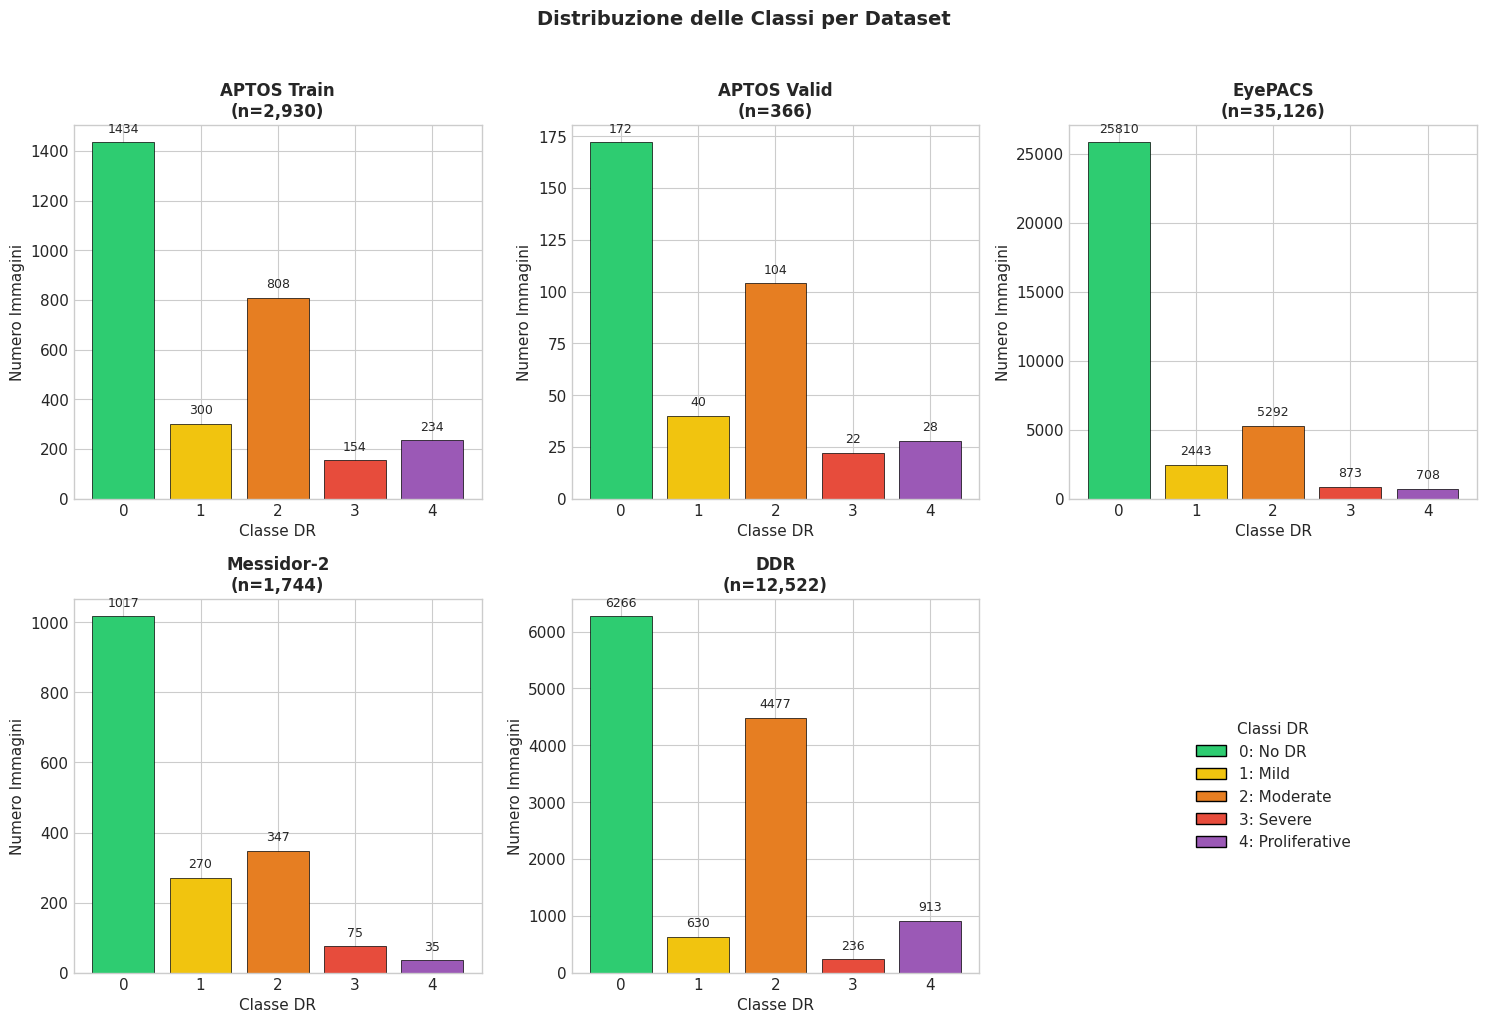

In [42]:
# Grafico a barre della distribuzione per dataset
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

datasets_to_plot = [
    ('APTOS Train', aptos_train),
    ('APTOS Valid', aptos_valid),
    ('EyePACS', eyepacs_labels),
    ('Messidor-2', messidor),
    ('DDR', ddr_all)
]

for idx, (name, df) in enumerate(datasets_to_plot):
    ax = axes[idx]
    
    # Conteggio per classe
    counts = df['diagnosis'].value_counts().sort_index()
    
    # Colori per ogni barra
    colors = [DR_COLORS[i] for i in counts.index]
    
    # Creazione grafico
    bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black', linewidth=0.5)
    
    # Etichette sopra le barre
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
                f'{count}', ha='center', va='bottom', fontsize=9)
    
    ax.set_title(f'{name}\n(n={len(df):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Classe DR')
    ax.set_ylabel('Numero Immagini')
    ax.set_xticks(range(5))
    ax.set_xticklabels([f'{i}' for i in range(5)])

# Nascondo l'ultimo subplot vuoto
axes[5].axis('off')

# Legenda comune
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=DR_COLORS[i], edgecolor='black', 
                                  label=f'{i}: {DR_CLASSES[i]}') for i in range(5)]
axes[5].legend(handles=legend_elements, loc='center', fontsize=11, title='Classi DR')

plt.suptitle('Distribuzione delle Classi per Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Salvataggio figura
output_path = RESULTS_DIR / 'class_distribution_by_dataset.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Figura salvata in: {output_path}")
plt.show()

Figura salvata in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/results/class_distribution_comparison.png


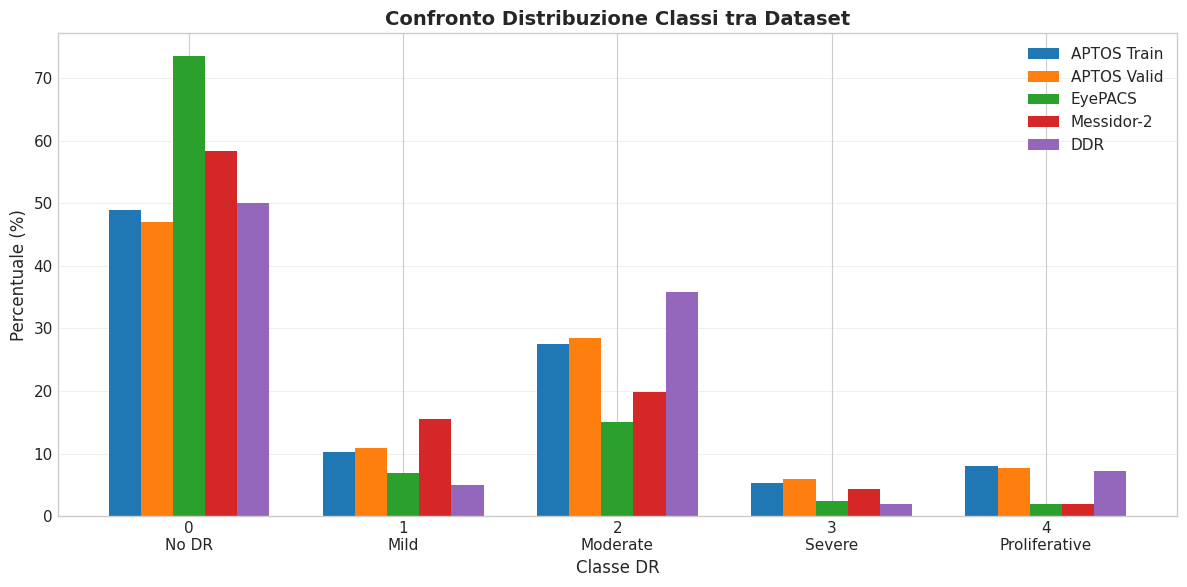

In [43]:
# Grafico comparativo delle percentuali
fig, ax = plt.subplots(figsize=(12, 6))

# Preparazione dati
x = np.arange(5)  # 5 classi
width = 0.15  # Larghezza barre

datasets_names = ['APTOS Train', 'APTOS Valid', 'EyePACS', 'Messidor-2', 'DDR']
datasets_dfs = [aptos_train, aptos_valid, eyepacs_labels, messidor, ddr_all]

for i, (name, df) in enumerate(zip(datasets_names, datasets_dfs)):
    # Calcolo percentuali per classe
    pcts = []
    for cls in range(5):
        count = len(df[df['diagnosis'] == cls])
        pcts.append(count / len(df) * 100)
    
    # Posizione barre
    offset = (i - 2) * width
    bars = ax.bar(x + offset, pcts, width, label=name)

ax.set_xlabel('Classe DR', fontsize=12)
ax.set_ylabel('Percentuale (%)', fontsize=12)
ax.set_title('Confronto Distribuzione Classi tra Dataset', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i}\n{DR_CLASSES[i]}' for i in range(5)])
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Salvataggio figura
output_path = RESULTS_DIR / 'class_distribution_comparison.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Figura salvata in: {output_path}")
plt.show()

## 9. Analisi Class Imbalance

Calcoliamo metriche specifiche per quantificare lo sbilanciamento delle classi.

In [44]:
def calculate_imbalance_ratio(df, label_col='diagnosis'):
    """
    Calcola il rapporto di sbilanciamento tra la classe piu frequente e quella meno frequente.
    
    Args:
        df: DataFrame con le annotazioni
        label_col: Nome della colonna contenente le label
        
    Returns:
        Tuple (imbalance_ratio, majority_class, minority_class)
    """
    counts = df[label_col].value_counts()
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    imbalance_ratio = counts.max() / counts.min()
    return imbalance_ratio, majority_class, minority_class

print("Analisi Class Imbalance")
print("=" * 60)

for name, df in [('APTOS Train', aptos_train), ('EyePACS', eyepacs_labels), 
                 ('Messidor-2', messidor), ('DDR', ddr_all)]:
    ratio, maj, minor = calculate_imbalance_ratio(df)
    print(f"\n{name}:")
    print(f"  Classe maggioritaria: {maj} ({DR_CLASSES[maj]})")
    print(f"  Classe minoritaria: {minor} ({DR_CLASSES[minor]})")
    print(f"  Rapporto di sbilanciamento: {ratio:.1f}:1")

Analisi Class Imbalance

APTOS Train:
  Classe maggioritaria: 0 (No DR)
  Classe minoritaria: 3 (Severe)
  Rapporto di sbilanciamento: 9.3:1

EyePACS:
  Classe maggioritaria: 0 (No DR)
  Classe minoritaria: 4 (Proliferative)
  Rapporto di sbilanciamento: 36.5:1

Messidor-2:
  Classe maggioritaria: 0 (No DR)
  Classe minoritaria: 4 (Proliferative)
  Rapporto di sbilanciamento: 29.1:1

DDR:
  Classe maggioritaria: 0 (No DR)
  Classe minoritaria: 3 (Severe)
  Rapporto di sbilanciamento: 26.6:1


In [45]:
# Dataset combinato per training (APTOS + EyePACS)
# Come specificato nella proposta, questi due dataset verranno uniti

# Nota: per ora creiamo solo il DataFrame delle label
# Il merge effettivo delle immagini verra fatto nel preprocessing

combined_train = pd.concat([
    aptos_train.assign(source='APTOS'),
    eyepacs_labels.assign(source='EyePACS')
], ignore_index=True)

print("Dataset Combinato (APTOS + EyePACS) per Training")
print("=" * 60)
print(f"Totale immagini: {len(combined_train):,}")
print(f"  - Da APTOS: {len(aptos_train):,}")
print(f"  - Da EyePACS: {len(eyepacs_labels):,}")

print("\nDistribuzione classi nel dataset combinato:")
combined_dist = combined_train['diagnosis'].value_counts().sort_index()
for label, count in combined_dist.items():
    pct = count / len(combined_train) * 100
    print(f"  Classe {label} ({DR_CLASSES[label]}): {count:,} ({pct:.1f}%)")

ratio, maj, minor = calculate_imbalance_ratio(combined_train)
print(f"\nRapporto di sbilanciamento: {ratio:.1f}:1")

Dataset Combinato (APTOS + EyePACS) per Training
Totale immagini: 38,056
  - Da APTOS: 2,930
  - Da EyePACS: 35,126

Distribuzione classi nel dataset combinato:
  Classe 0 (No DR): 27,244 (71.6%)
  Classe 1 (Mild): 2,743 (7.2%)
  Classe 2 (Moderate): 6,100 (16.0%)
  Classe 3 (Severe): 1,027 (2.7%)
  Classe 4 (Proliferative): 942 (2.5%)

Rapporto di sbilanciamento: 28.9:1


## 10. Verifica Esistenza File Immagini

Verifichiamo che i file delle immagini esistano effettivamente nelle cartelle.

In [46]:
def check_images_exist(df, image_dir, id_col='id_code', extension=None):
    """
    Verifica quali immagini del DataFrame esistono nella directory specificata.
    
    Args:
        df: DataFrame con gli ID delle immagini
        image_dir: Directory contenente le immagini
        id_col: Nome della colonna con gli ID
        extension: Estensione del file (es. '.png'). Se None, cerca qualsiasi estensione.
        
    Returns:
        Tuple (found_count, missing_count, missing_ids)
    """
    image_dir = Path(image_dir)
    
    # Lista tutti i file nella directory
    if image_dir.exists():
        existing_files = {f.stem: f.name for f in image_dir.iterdir() if f.is_file()}
    else:
        return 0, len(df), df[id_col].tolist()
    
    found = 0
    missing = []
    
    for img_id in df[id_col]:
        # Rimuovi eventuale estensione dall'ID
        img_id_clean = Path(img_id).stem
        
        if img_id_clean in existing_files:
            found += 1
        else:
            missing.append(img_id)
    
    return found, len(missing), missing[:10]  # Ritorna solo i primi 10 mancanti

print("Verifica Esistenza File Immagini")
print("=" * 60)

# APTOS
found, missing, sample = check_images_exist(aptos_train, APTOS_DIR / 'train_images')
print(f"\nAPTOS Train: {found}/{len(aptos_train)} trovate, {missing} mancanti")
if missing > 0:
    print(f"  Esempio mancanti: {sample}")

# EyePACS
found, missing, sample = check_images_exist(eyepacs_labels, EYEPACS_DIR / 'train')
print(f"\nEyePACS: {found}/{len(eyepacs_labels)} trovate, {missing} mancanti")
if missing > 0:
    print(f"  Esempio mancanti: {sample}")

# Messidor-2
found, missing, sample = check_images_exist(messidor, MESSIDOR_DIR / 'images')
print(f"\nMessidor-2: {found}/{len(messidor)} trovate, {missing} mancanti")
if missing > 0:
    print(f"  Esempio mancanti: {sample}")

# DDR
found, missing, sample = check_images_exist(ddr_all, DDR_DIR / 'train')
print(f"\nDDR (cartella train): {found}/{len(ddr_train)} trovate")

Verifica Esistenza File Immagini

APTOS Train: 2930/2930 trovate, 0 mancanti

EyePACS: 35126/35126 trovate, 0 mancanti

Messidor-2: 1744/1744 trovate, 0 mancanti

DDR (cartella train): 6260/6260 trovate


## 11. Salvataggio Dataset Unificati

Salviamo i DataFrame processati in formato CSV per utilizzo nei prossimi notebook.

In [47]:
# Creazione directory per i dati processati
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)

# Salvataggio dei dataset con formato unificato
# Colonne: id_code, diagnosis, source (opzionale), split (opzionale)

# APTOS
aptos_all = pd.concat([
    aptos_train.assign(split='train'),
    aptos_valid.assign(split='valid')
])
aptos_all['source'] = 'APTOS'
aptos_all.to_csv(PROCESSED_DIR / 'aptos_unified.csv', index=False)

# EyePACS
eyepacs_labels['source'] = 'EyePACS'
eyepacs_labels['split'] = 'train'  # Tutto il dataset e per training
eyepacs_labels.to_csv(PROCESSED_DIR / 'eyepacs_unified.csv', index=False)

# Messidor-2
messidor['source'] = 'Messidor2'
messidor['split'] = 'test'  # Usato per validazione esterna
messidor.to_csv(PROCESSED_DIR / 'messidor2_unified.csv', index=False)

# DDR
ddr_all_unified = pd.concat([
    ddr_train.assign(split='train'),
    ddr_valid.assign(split='valid'),
    ddr_test.assign(split='test')
])
ddr_all_unified['source'] = 'DDR'
ddr_all_unified.to_csv(PROCESSED_DIR / 'ddr_unified.csv', index=False)

# Dataset combinato per training CNN (APTOS + EyePACS)
combined_train.to_csv(PROCESSED_DIR / 'combined_train.csv', index=False)

print("Dataset salvati in:", PROCESSED_DIR)
print("\nFile creati:")
for f in PROCESSED_DIR.glob('*.csv'):
    df = pd.read_csv(f)
    print(f"  - {f.name}: {len(df):,} righe")

Dataset salvati in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed

File creati:
  - aptos_unified.csv: 3,296 righe
  - combined_train.csv: 38,056 righe
  - ddr_unified.csv: 12,522 righe
  - eyepacs_unified.csv: 35,126 righe
  - messidor2_unified.csv: 1,744 righe


## 12. Conclusioni

### Riepilogo dell'Analisi

**Dataset per Training CNN:**
- APTOS 2019 + EyePACS 2015 = ~38,788 immagini
- Forte sbilanciamento verso classe 0 (No DR) - circa 70%
- La Focal Loss aiutera a gestire questo sbilanciamento

**Dataset per Testing:**
- Messidor-2 = ~1,744 immagini per validazione esterna

**Dataset per XAI Validation:**
- DDR = 757 immagini con annotazioni pixel-level (dopo filtraggio classe 5)
- Utile per calcolare IoU tra Grad-CAM e lesioni reali

### Prossimi Passi
1. Preprocessing delle immagini (resize, normalizzazione)
2. Creazione dei DataLoader per il training
3. Implementazione del modello EfficientNet-B5

In [48]:
# Salvataggio del riepilogo finale
summary_final = {
    'Dataset': ['APTOS 2019', 'EyePACS 2015', 'Combined (Training)', 'Messidor-2 (Test)', 'DDR (XAI)'],
    'Immagini': [len(aptos_all), len(eyepacs_labels), len(combined_train), len(messidor), len(ddr_all_unified)],
    'Utilizzo': ['Training', 'Training', 'Training CNN', 'External Validation', 'XAI Validation']
}

summary_final_df = pd.DataFrame(summary_final)
print("\nRiepilogo Finale Dataset")
print("=" * 60)
display(summary_final_df)


Riepilogo Finale Dataset


,Dataset,Immagini,Utilizzo
0,APTOS 2019,3296,Training
1,EyePACS 2015,35126,Training
2,Combined (Training),38056,Training CNN
3,Messidor-2 (Test),1744,External Validation
4,DDR (XAI),12522,XAI Validation
